## Phase 1:
-   CTPN
-   SVN

### Load file path

In [2]:
from os import walk
import numpy as np
import matplotlib.pyplot as plt
import PIL
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

In [46]:
# get link of ads and non ads images
from os import walk
f_test = []
ctpn_output_test = "../data/dataset/ctpn_output/testing_data/"
for dirpath, dirnames, filenames in os.walk(ctpn_output_test):
    f_test.append(filenames)
    break
f_test = f_test[0]

In [48]:
ads_test_data = []
for name in f_test:
    ads_test_data.append([i[:-1] for i in open(ctpn_output_test + name,'r').readlines() if i !="\n"])

Get height and width of image

In [49]:
img_test_path = "../data/dataset/testing_data"
hw_test = [PIL.Image.open(img_test_path + "/" + name[:-3] + "png").size for name in f_test] 

In [50]:
def extract_info(arr):
    arr = [int(i) for i in arr.split(",")[:-1]]
    h_b = arr[-1]-arr[1]
    w_b = arr[2] - arr[0]
    h_cb = (arr[-1]+arr[1])//2
    w_cb = (arr[2]+arr[0])//2
    return h_b,w_b,h_cb,w_cb

In [51]:
def sort_weight(bb, temp_scale,temp_distance=None):
    if temp_distance != None:
        temp_scale_sort = sorted(temp_scale)
        temp_distance_sort = sorted(temp_distance)
        bb_t = set()
        for distance in temp_distance_sort[-n_att:]:
            bb_t.add(bb[temp_distance_sort.index(distance)])
        for scale in temp_scale_sort[-n_att:]:
            bb_t.add(bb[temp_scale_sort.index(scale)])
        return list(bb_t),temp_scale_sort[-n_att:] + temp_distance_sort[-n_att:]
    else:
        w = sorted(temp_scale)
        bb_t = []
        for i in range(n_att):
            bb_t.append(bb[temp_scale.index(w[-n_att+i])])
        return bb_t,w[-n_att:]

$$x = max(H_b/W_b) +...+ max ((|H_cb-H_c+1)*(|W_cb-W_c+1)/(H_c*W_c))$$

In [52]:
n_att = 10
w_test = []
for bbs,hw in zip(ads_test_data,hw_test):
    if len(bbs) <n_att:
        continue
    temp_scale = []
    temp_distance = []
    for bb in bbs:
        h_b,w_b,h_cb,w_cb =extract_info(bb)
        weight = (3*h_b*(abs(h_cb-hw[1])+1)*(abs(w_cb-hw[0])+1))/w_b
        temp_scale.append(h_b/w_b)
        temp_distance.append((abs(h_cb-hw[1])+1)*(abs(w_cb-hw[0])+1)/(hw[0]*hw[1]))
    bb_t, w_t = sort_weight(bbs, temp_scale,temp_distance)
    w_test.append(w_t)


In [53]:
X_test = w_test
y_test = [0]*len(w_test)
for i in range(len(f_test)):
    if f_test[i][:3] == "ads":
        y_test[i] = 1

## Load SVM by joblid

In [107]:
import joblib
import sklearn.metrics as metrics

In [167]:
clf2 = joblib.load("../phase_1/svm_phase_1_v2.pkl")
clf2.probability = True
test_phase_1 = [[i[0],i[1]] for i in clf2.predict_proba(X_test)]

In [168]:
y_test[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [169]:
test_phase_1[:10]

[[0.9330630011722724, 0.0669369988277276],
 [0.5087130876706271, 0.49128691232937305],
 [0.8106662835023474, 0.18933371649765254],
 [0.9358970039247465, 0.06410299607525352],
 [0.8943587241859536, 0.10564127581404649],
 [0.9704640733549801, 0.02953592664501997],
 [0.912386283667497, 0.08761371633250299],
 [0.9751716174878288, 0.024828382512171197],
 [0.4432750450126529, 0.5567249549873472],
 [0.476050081291567, 0.523949918708433]]

In [115]:
y_test_phase_1 = [0] * len(y_test)
for i,r in enumerate(test_phase_1):
    if r[0] > r[1]:
        y_test_phase_1[i] = 1

In [116]:
metrics.confusion_matrix(y_test,y_test_phase_1)

array([[266,  27],
       [ 23, 350]], dtype=int64)

In [118]:
metrics.accuracy_score(y_test,y_test_phase_1)

0.924924924924925

## Phase 2:
-   Xception

In [17]:
from tensorflow.keras.models import load_model
import os

In [18]:
from PIL import Image
import numpy as np
from skimage import transform
import shutil
import keras
import tensorflow as tf

In [19]:
def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')
    np_image = transform.resize(np_image,(180,180,3))
    np_image = np.expand_dims(np_image, axis = 0)
    return np_image

In [120]:
model_phase_2 = load_model('../phase_2/xception/model/save_at_40.h5')

In [127]:
test_phase_2 = []
for name in f_test:
    r =model_phase_2.predict(load(img_test_path +'/'+ name[:-3] + "png"))
    test_phase_2.append([1-r[0][0], r[0][0]])

In [130]:
test_phase_2[:10]

[[0.9996516704559326, 0.00034832954],
 [0.9999997151579407, 2.8484206e-07],
 [0.9999689133983338, 3.10866e-05],
 [0.9995241463184357, 0.00047585368],
 [0.9996791481971741, 0.0003208518],
 [0.9999999972622811, 2.737719e-09],
 [0.99847012758255, 0.0015298724],
 [0.9999999709479699, 2.905203e-08],
 [0.9999993381081822, 6.618918e-07],
 [0.9999999221356433, 7.786436e-08]]

In [131]:
y_phase_2 = [0] * len(y_train)
for i,r in enumerate(test_phase_2):
    if r[0] > r[1]:
        y_phase_2[i] = 1

In [132]:
metrics.confusion_matrix(y_train,y_phase_2)

array([[682,   0],
       [455, 415]], dtype=int64)

In [26]:
metrics.accuracy_score(y,y_phase2)

0.918918918918919

### Save results of phase_1 and phase_2

In [27]:
import pickle

In [189]:
with open("./test_phase_1.pkl", "wb") as f:
    pickle.dump([list(i) for i in test_phase_1],f)
with open("./test_phase_2.pkl", "wb") as f:
    pickle.dump(test_phase_2,f)

### Load phase_1 and phase_2

In [37]:
# with open("./phase_1.pkl", "rb") as f:
#     phase_1 = pickle.load(f)
# with open("./phase_2.pkl", "rb") as f:
#     phase_2 = pickle.load(f)

## Evaluating model

In [29]:

import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd

### 1. Mean of 2 phases

In [30]:
y_pred = [0]*len(y)
for i in range(len(y)):
    ads_r = (phase_1[i][0] + phase_2[i][0])/2
    non_ads_r = (phase_1[i][1] + phase_2[i][1])/2
    if ads_r > non_ads_r:
        y_pred[i] = 1

In [31]:
r = metrics.confusion_matrix(y, y_pred)
print("Confusion matrix: \n", r)

Confusion matrix: 
 [[273  20]
 [  6 367]]


In [32]:
acc = metrics.accuracy_score(y, y_pred)
print("Accuracy: ", acc)

Accuracy:  0.960960960960961


<AxesSubplot:>

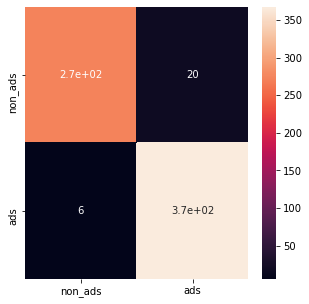

In [33]:
df_cm = pd.DataFrame(r, index = ['non_ads','ads'],
                  columns = ['non_ads','ads'])
plt.figure(figsize = (5,5))
sn.heatmap(df_cm, annot=True)

### 2. Using Neural Network to combines 2 phases

#### Train phase 1 using SVM

In [44]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import sklearn.metrics as metrics

In [152]:
f = []
ctpn_output_train = "../data/dataset/ctpn_output/training_data/"
for dirpath, dirnames, filenames in os.walk(ctpn_output_train):
    f.append(filenames)
    break
f = f[0]
ads_train_data = []
for name in f:
    ads_train_data.append([i[:-1] for i in open(ctpn_output_train + name,'r').readlines() if i !="\n"])

In [134]:
img_train_path = "../data/dataset/training_data/"
hw_train = [PIL.Image.open(img_train_path + "/" + name[:-3] + "png").size for name in f] 
n_att = 10
w_train = []
for bbs,hw in zip(ads_train_data,hw_train):
    if len(bbs) <n_att:
        continue
    temp_scale = []
    temp_distance = []
    for bb in bbs:
        h_b,w_b,h_cb,w_cb =extract_info(bb)
        weight = (3*h_b*(abs(h_cb-hw[1])+1)*(abs(w_cb-hw[0])+1))/w_b
        temp_scale.append(h_b/w_b)
        temp_distance.append((abs(h_cb-hw[1])+1)*(abs(w_cb-hw[0])+1)/(hw[0]*hw[1]))
    bb_t, w_t = sort_weight(bbs, temp_scale,temp_distance)
    w_train.append(w_t)


In [135]:
X_train = w_train
y_train = [0]*len(w_train)
for i in range(len(f)):
    if f[i][:3] == "ads":
        y_train[i] = 1

In [136]:
clf = SVC(C=1.0, kernel='rbf', probability=True).fit(X_train,y_train)
clf.probability = True

In [138]:
train_phase_1 =[[i[1],i[0]] for i in clf.predict_proba(X_train)]

In [139]:
train_phase_1[:10]

[[0.8577902247675546, 0.14220977523244543],
 [0.5159307816620388, 0.4840692183379611],
 [0.9707637909423362, 0.029236209057663866],
 [0.5461971573988542, 0.4538028426011457],
 [0.8241549489221777, 0.17584505107782228],
 [0.7972513108655531, 0.20274868913444702],
 [0.9814176349186965, 0.018582365081303478],
 [0.9470908856876485, 0.052909114312351305],
 [0.8310325692305038, 0.16896743076949622],
 [0.9310521825485829, 0.06894781745141688]]

#### Train phase 2 use Xception

In [85]:
from tensorflow.keras.models import load_model
import os
from PIL import Image
import numpy as np
from skimage import transform
import shutil
import keras
import tensorflow as tf

In [153]:
train_phase_2 = []
for name in f:
    r =model_phase_2.predict(load(img_train_path + name[:-3] + "png"))
    train_phase_2.append([1-r[0][0], r[0][0]])

In [188]:
# Save list result of phase 1 and 2
with open("./train_phase_1.pkl", "wb") as file_io:
    pickle.dump(train_phase_1,file_io)
with open("./train_phase_2.pkl", "wb") as file_io:
    pickle.dump(train_phase_2,file_io)

In [34]:
from keras.models import Sequential
from keras.layers import Dense

### Train Neural Network

In [92]:
X = [train_phase_1[i] + train_phase_2[i] for i in range(len(train_phase_1))]
y = y_train

In [158]:

# define the keras model
model =Sequential()
model.add(Dense(16, input_dim=4, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [159]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [160]:
model.fit(X,y,epochs=100,batch_size=10)

Epoch 1/100
156/156 [==============================] - 1s 1ms/step - loss: 0.5319 - accuracy: 0.8267
Epoch 2/100
156/156 [==============================] - 0s 1ms/step - loss: 0.3762 - accuracy: 0.9671
Epoch 3/100
156/156 [==============================] - 0s 1ms/step - loss: 0.3340 - accuracy: 0.9723
Epoch 4/100
156/156 [==============================] - 0s 1ms/step - loss: 0.3016 - accuracy: 0.9736
Epoch 5/100
156/156 [==============================] - 0s 1ms/step - loss: 0.2749 - accuracy: 0.9762
Epoch 6/100
156/156 [==============================] - 0s 1ms/step - loss: 0.2512 - accuracy: 0.9762
Epoch 7/100
156/156 [==============================] - 0s 1ms/step - loss: 0.2314 - accuracy: 0.9755
Epoch 8/100
156/156 [==============================] - 0s 1ms/step - loss: 0.2131 - accuracy: 0.9787
Epoch 9/100
156/156 [==============================] - 0s 1ms/step - loss: 0.1992 - accuracy: 0.9781
Epoch 10/100
156/156 [==============================] - 0s 1ms/step - loss: 0.1851 - accura

### Evaluating NN for 2 phases

In [184]:
y_pred = model.predict([test_phase_1[i] + test_phase_2[i] for i in range(len(test_phase_1))])

In [185]:
y_pred = [1 if i >= 0.5 else 0 for i in y_pred]

In [186]:
metrics.confusion_matrix(y_test,y_pred)

array([[282,  11],
       [ 11, 362]], dtype=int64)

In [187]:
metrics.accuracy_score(y_test,y_pred)

0.9669669669669669